# ДЗ №5 Сегментация
Реализация сети для сегметации объектов.

__Задача__ сделать работоспособную сеть для сегментирования изображений авто на основе предложенного шаблона


![Segmentation](../img/Segment04.png)

### Что делаем
Реализуем сверточную сеть для семантической сегментации, downsample->upsample -> Классификация каждого пикселя выходного изображения: 0 - не авто, 1 - авто. Выход картинка с x каналами, для классификации.
1. В файле model.py   - имплементировать модель вместо заглушки
2. В файле train.py - поставить правильный loss

### Данные
[Carvana](https://cloud.mail.ru/public/3tdq/AvtaHkDAb)

### Зависимости
 - tensorflow  - поддержка tensorboard
 - tensorboardx - тензор боард для pytorch
 - tqdm         - пакет для отрисовки прогресс баров

### Запуск пакета
_ По умолчанию все данные лежат в папке ./data/. Если вы положили их в другую папку, то поправте в скрипте train.py пути _
<br/>
Запускаем обучение сети
python train.py

Результаты обучение можно наблюдать в tensorboard

Запуск tensorboard --log ./od_log

## Результаты
1. Код model.py, train.py
2. Модель state_dicts()

### Тут нужно сделать загрузку состояния вашей модели, код модели в ноутбук тащить не нужно, достаточно сделать import model


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import torch.nn as nn
def segnetDown(in_size, out_size):
    net = nn.Sequential(nn.Conv2d(in_size, out_size,  stride=1,kernel_size=3, padding=1, bias=False),
                         nn.BatchNorm2d(out_size),
                         nn.ReLU(inplace=True),
                         nn.Conv2d(out_size, out_size,  stride=1,kernel_size=3, padding=1, bias=False),
                         nn.BatchNorm2d(out_size),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(2, 2, return_indices=True)
                       )
    return net;

def segnetUp(in_size, out_size):
    net = nn.Sequential(nn.MaxUnpool2d(2, 2),
                         nn.Conv2d(in_size, out_size,  stride=1,kernel_size=3, padding=1, bias=False),
                         nn.BatchNorm2d(out_size),
                         nn.ReLU(inplace=True)
                         nn.Conv2d(out_size, out_size,  stride=1,kernel_size=3, padding=1, bias=False)
                         nn.BatchNorm2d(out_size),
                         nn.ReLU(inplace=True)
                       )
    return net;


# In[ ]:


class segnet(nn.Module):
    def __init__(self, n_classes=2, in_channels=3, is_unpooling=True):
        super(segnet, self).__init__()
        
        self.in_channels = in_channels
        self.is_unpooling = is_unpooling
        self.n_classes = n_classes
        self.down1 = segnetDown(self.in_channels,64)
        self.down2 = segnetDown(64, 128)
        self.down3 = segnetDown(128, 256)
        self.down4 = segnetDown(256, 512)
        self.up4 = segnetUp(512, 256)
        self.up3 = segnetUp(256, 128)
        self.up2 = segnetUp(128, 64)
        self.up1 = segnetUp(64, self.n_classes)
        self.softmax= nn.Softmax2d()
    def forward(self, inputs):
        outputs, indices_1 = self.down1(inputs)
        outputs, indices_2 = self.down2(outputs)
        outputs, indices_3 = self.down3(outputs)
        outputs, indices_4 = self.down4(outputs)
        outputs = self.up4(outputs, indices_4 )
        outputs = self.up3(outputs, indices_3)
        outputs = self.up2(outputs, indices_2)
        outputs = self.up1(outputs, indices_1)
        outputs = self.softmax(outputs)
        return outputs


# In[ ]:

In [4]:
# TODO
# import model ....
# Загружаем модель 
import torch
import torch.nn as nn
import torch.utils.data as dt
from carvana_dataset import CarvanaDataset
from model import segnet
from torch.autograd import Variable
import torch.optim as optim
from tensorboardX import SummaryWriter
import os
from tqdm import *
import numpy as np
model= segnet()
model.load_state_dict(torch.load('/media/denis/b80fa2a5-44af-425c-bdb4-8d3f9d0f5605/denis/homework/hw5/model_1.pt'))
model.eval()

segnet(
  (down1): segnetDown(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): segnetDown(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [6]:
## Реализуем тест модели на тестовом сете
## for ....
## замеряем среднюю метрику по тестовому сету, пример кода есть в train.py
import numpy as np
from sklearn.metrics import accuracy_score
m=model
m.cuda()
test = '/media/denis/b80fa2a5-44af-425c-bdb4-8d3f9d0f5605/denis/homework/hw5/test/'
test_masks = '/media/denis/b80fa2a5-44af-425c-bdb4-8d3f9d0f5605/denis/homework/hw5/test_masks/'
ds_test = CarvanaDataset(test, test_masks)

dl_test = dt.DataLoader(ds_test, shuffle=False, num_workers=0, batch_size=1)
accuracy=[]
for iter, (i, t) in enumerate(tqdm(dl_test)):
        i = Variable(i, volatile = True)
        t = Variable(t, volatile = True)
        i = i.cuda()
        t = t.cuda()
        o = m(i)
        o=o[:,1].view(-1) 
        t=t.view(-1) 
        o=torch.tensor(o, dtype=torch.int)
        t=torch.tensor(t, dtype=torch.int)
        acc=accuracy_score(t, o)
        c.append(acc)

/home/denis/anaconda3/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  0%|          | 0/508 [00:00<?, ?it/s]/home/denis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app
/home/denis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
100%|██████████| 508/508 [00:24<00:00, 21.18it/s]


In [7]:
np.mean(accuracy)

0.8529929765336254

### Тут нужно нарисовать картинки, с результатими сегментации из тестового сета

In [16]:
# TODO
# Для рандомного изображения рисуем его маску сгенерированную сеткой, само изображение и результат сегментации
import torchvision.transforms as transforms
from PIL import Image
input_size = 224
data_path='/media/denis/b80fa2a5-44af-425c-bdb4-8d3f9d0f5605/denis/homework/hw5/test/'
mask_path= '/media/denis/b80fa2a5-44af-425c-bdb4-8d3f9d0f5605/denis/homework/hw5/test_masks'
files=os.listdir(data_path)
files.sort()

i=np.random.randint(0,len(files))

mask_files = os.listdir(mask_path)
mask_files.sort()

f_name = os.path.join(data_path, files[i])

def pil_load(path, is_input=True):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                return img.convert('RGB')
            
preprocess = transforms.Compose([
            transforms.Scale((input_size, input_size)),
            transforms.ToTensor()
        ])           

input = pil_load(f_name)
input = preprocess(input)

f_name_mask= os.path.join(mask_path, mask_files[i])
input_mask=pil_load(f_name_mask)
input_mask=preprocess(input_mask)

/home/denis/anaconda3/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

<function matplotlib.pyplot.show(*args, **kw)>

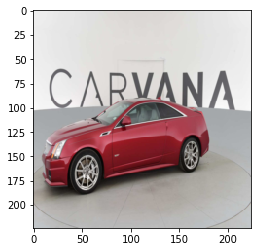

In [17]:
inputs = input.permute(1, 2, 0)
plt.imshow(inputs)
plt.show

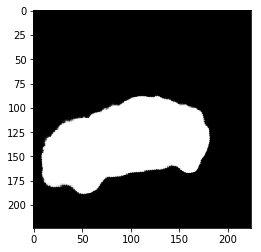

In [18]:
results=m(input.unsqueeze(0).cuda())
results=results.squeeze(0)
result=results[1].cpu().detach().numpy()
plt.imshow(result, cmap='gray')

<function matplotlib.pyplot.show(*args, **kw)>

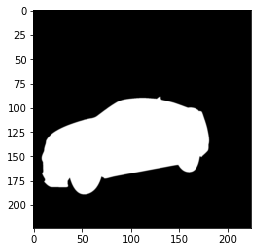

In [19]:
inputs_mask = input_mask.permute(1, 2, 0)
plt.imshow(inputs_mask)
plt.show